The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1784, 2017)


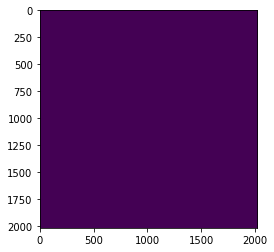

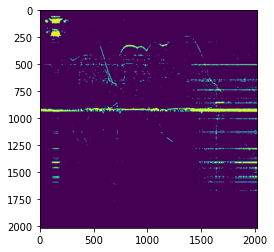

In [11]:
from whiteboard import Whiteboard
from operator import matmul
import skvideo.io  
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, laplace
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil, floor,  pi, sqrt
import imageio as iio
from PIL import Image
from skimage import color
from skimage import io

%load_ext autoreload
%autoreload 2
imgGray = color.rgb2gray(cv2.imread('../../data/angle_left.png'))
#imgGray = color.rgb2gray(img)
print(imgGray.shape)
whiteboard = Whiteboard(imgGray)
t = whiteboard.r > 0.005
plt.imshow(t)


R(16:22, 16:22)
[[ 4.2932577e+00  1.8014120e+01  1.4483400e-01  4.1639694e+01
   3.8660458e+01  1.9077743e+00]
 [ 2.3971619e-01  2.2413300e+01  1.1861403e+01  6.5843987e-01
   2.1901571e+01  3.3105534e+01]
 [ 1.9882976e+00  6.3555998e-01  5.8524342e+00  8.6481352e+00
   6.1547714e-01  6.4231439e+00]
 [ 9.9400721e+00  6.7827330e+00  6.9089189e-02  7.5358286e+00
   1.5766747e+01  3.2244480e+00]
 [ 7.8337464e+00  4.9518547e+00  1.0998894e+00  8.3931130e-01
   5.1234975e+00  5.0306700e-02]
 [ 2.0134786e-01  1.9770472e-01 -4.1522462e-02  2.2640054e-01
   1.2046939e+00  8.1831894e+00]]


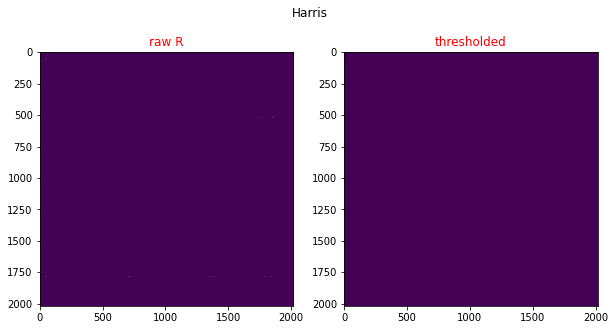

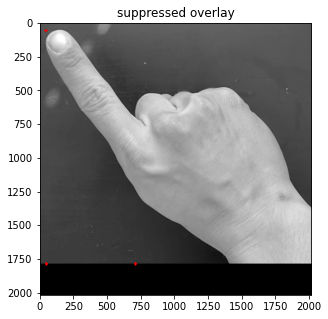

In [17]:

def gaussDeriv2D(sigma):
    x = np.array(range(0, 6*ceil(sigma)))
    y = np.transpose(x)
    Gx = ((x-3*ceil(sigma))/(2*pi*sigma**4)) * \
        (np.exp(-(((x-3*ceil(sigma))**2+(y-3*ceil(sigma))**2)/(2*sigma**2))))
    Gy = ((y-3*ceil(sigma))/(2*pi*sigma**4)) * \
        (np.exp(-(((x-3*ceil(sigma))**2+(y-3*ceil(sigma))**2)/(2*sigma**2))))
    return [Gx, Gy[np.newaxis]]

from skimage.color import rgb2gray
checker = rgb2gray(plt.imread('../../data/angle_left.png')[:,:,:3]*255)
checker = np.pad(checker, ((0, 233), (0, 0)), 'constant')
alpha = 0.05
dx, dy = gaussDeriv2D(0.7)

ix = cv2.filter2D(checker, -1, dx)
iy = cv2.filter2D(checker, -1, dy)

ix2 = np.square(ix)
iy2 = np.square(iy)
ixiy = ix @ iy

gx = cv2.GaussianBlur(ix2, (3, 3), 1)
gy = cv2.GaussianBlur(iy2, (3, 3), 1)
gxgy = cv2.GaussianBlur(ixiy, (3, 3), 1)

R = gx*gy - np.square(gxgy) - alpha*np.square(gx+gy)
# for some reason I get negative significant values instead of positive?
R = -R
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(R)
plt.gca().set_title('raw R', c='r')
# remove vals less than 1e6
threshold = np.where(R < 1e6, 0, R)
plt.subplot(1, 2, 2)
plt.imshow(threshold)
plt.gca().set_title('thresholded', c='r')
print('R(16:22, 16:22)')
print(R[16:22, 16:22])

w_size = 50
limits = threshold.shape[0]-w_size, threshold.shape[1]-w_size
suppress = []
for r, c in np.ndindex(limits):
    region = threshold[r-1:r+1, c-1:c+1]
    if np.unique(region).size > 0:
        if np.max(np.unique(region)) > 0:
            suppress.append((c, r))

plt.suptitle('Harris')
plt.show()

plt.figure(figsize=(5, 5))
plt.gca().imshow(checker, cmap='gray')
plt.gca().scatter(*zip(*suppress), s=0.5, c='r')
plt.title('suppressed overlay')
plt.show()
